# Download and install required packages

In [ ]:
# import scipy
# scipy.__version__

In [ ]:
# !pip install gdown
# !pip install Pillow
# !pip install imageio

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# download final dataset

In [ ]:
import gdown 
url = 'https://drive.google.com/u/0/uc?export=download&confirm=GhvJ&id=1-Lwq3puZHwM-BIarLlUOPxc4BC2VwFgf' 
output = 'final.zip' 
gdown.download(url, output, quiet=False) 

In [ ]:
# check integrity of dataset
!md5sum drive/MyDrive/GR_phase2/final.zip

dfd6817819611f358327501f6e551a30  drive/MyDrive/GR_phase2/final.zip


In [ ]:
# unzip
!unzip -q final.zip

In [ ]:
!ls

datasets  drive  final.zip  sample_data


# Imports 

In [ ]:
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from PIL import Image
np.random.seed(30)
import random as rn
rn.seed(30)

import os
from glob import glob

from keras import backend as K
import tensorflow as tf
tf.random.set_seed(1234)

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

import imageio
from PIL import Image

import time
from keras.models import load_model

from keras.applications import mobilenet


In [ ]:
try:
    device_name = tf.test.gpu_device_name()
    print("Tensorflow version " + tf.__version__)

    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
except:
    pass

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    pass


Tensorflow version 2.4.1
Found GPU at: /device:GPU:0


In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Phase 2

## Model

In [ ]:
class CMAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self, train_path="datasets/train", val_path="datasets/test"):
        self.train_path = train_path
        self.val_path = val_path
        tras = [y for x in os.walk(train_path) for y in glob(os.path.join(x[0], '*.jpg'))]
        vals = [y for x in os.walk(val_path) for y in glob(os.path.join(x[0], '*.jpg'))]
        self.train_doc = np.random.permutation(tras)
        self.val_doc = np.random.permutation(vals)
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=200,image_width=200):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=29
          
    def initialize_hyperparams(self,batch_size=20,num_epochs=20):
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self,source_path, folder_list, augment=False):
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 

            image = imageio.imread(t[folder + (batch*batch_size)])
            image_resized=np.array((Image.fromarray(image).resize(size=(self.image_height,self.image_width)))).astype(np.float32)

            batch_data[folder,:,:,0] = (image_resized[:,:,0])/255
            batch_data[folder,:,:,1] = (image_resized[:,:,1])/255
            batch_data[folder,:,:,2] = (image_resized[:,:,2])/255
        
            if (augment):
                shifted = cv2.warpAffine(image, 
                                            np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                        (image.shape[1], image.shape[0]))
                
                gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                x0, y0 = np.argwhere(gray > 0).min(axis=0)
                x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                
                cropped=shifted[x0:x1,y0:y1,:]
                
                image_resized = np.array((Image.fromarray(cropped.astype(np.uint8)).resize(size=(self.image_height,self.image_width))))
 
                M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                            np.random.randint(-10,10), 1.0)
                rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
        
                batch_data_aug[folder,:,:,0] = (rotated[:,:,0])/255
                batch_data_aug[folder,:,:,1] = (rotated[:,:,1])/255
                batch_data_aug[folder,:,:,2] = (rotated[:,:,2])/255

            if str.isupper(t[folder + (batch*batch_size)].strip().split('/')[-1][2]):
                batch_labels[folder, ord(t[folder + (batch*batch_size)].strip().split('/')[-1][2])-ord('A')] = 1
            elif t[folder + (batch*batch_size)].strip().split('/')[-1][2] == 'n':
                batch_labels[folder, 26] = 1
            elif t[folder + (batch*batch_size)].strip().split('/')[-1][2] == 'd':
                batch_labels[folder, 27] = 1
            elif t[folder + (batch*batch_size)].strip().split('/')[-1][2] == 's':
                batch_labels[folder, 28] = 1
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'models/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists("models"):
            os.mkdir("models")

        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Training

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

class PM1(CMAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(mobilenet_transfer)
 
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
tpm1=PM1()
tpm1.initialize_path()
tpm1.initialize_image_properties(image_height=200,image_width=200)
tpm1.initialize_hyperparams(batch_size=10,num_epochs=3)
tpm1_model=tpm1.define_model(dense_neurons=128,dropout=0.25)
tpm1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 6, 6, 1024)        3228864   
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 1024)        4096      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 29)               

In [ ]:
print("Total Params:", tpm1_model.count_params())
history_model20=tpm1.train_model(tpm1_model,augment_data=True)

Total Params: 4416477
Epoch 1/3
12068/12068 [==============================] - 2995s 248ms/step - loss: 2.0444 - categorical_accuracy: 0.3714 - val_loss: 0.9857 - val_categorical_accuracy: 0.7230

Epoch 00001: saving model to models/model_init_2021-04-0813_25_48.118025/model-00001-1.39819-0.54373-0.98566-0.72300.h5
Epoch 2/3
12068/12068 [==============================] - 2977s 247ms/step - loss: 0.4992 - categorical_accuracy: 0.8420 - val_loss: 0.4537 - val_categorical_accuracy: 0.8890

Epoch 00002: saving model to models/model_init_2021-04-0813_25_48.118025/model-00002-0.39342-0.87913-0.45374-0.88900.h5
Epoch 3/3
12068/12068 [==============================] - 2946s 244ms/step - loss: 0.1912 - categorical_accuracy: 0.9456 - val_loss: 0.4659 - val_categorical_accuracy: 0.8940

Epoch 00003: saving model to models/model_init_2021-04-0813_25_48.118025/model-00003-0.16938-0.95240-0.46589-0.89400.h5


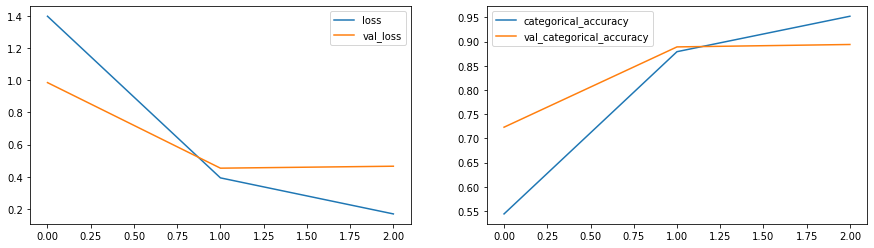

In [ ]:
plot(history_model20)

## Testing

In [ ]:
model = load_model('model-00002-0.39342-0.87913-0.45374-0.88900.h5')

test_generator=PM1()
test_generator.initialize_path()
test_generator.initialize_image_properties(image_height=200,image_width=200)
test_generator.initialize_hyperparams(batch_size=5,num_epochs=3)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:]),axis=1))